In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models
import benchmark.metrics as metrics
#import benchmark.models_tcrdist as models_tcrdist

In [4]:
tcr_columns_paired = {'TRA':['a_cdr3aa','TRAV','TRAJ'],'TRB':['b_cdr3aa','TRBV','TRBJ']}
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

# Clustering

## VDJdb

In [5]:
vdjdb_data_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv'

In [6]:

vdjdb_data = pd.read_csv(vdjdb_data_path,sep='\t')

In [7]:
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

In [ ]:
def tcrdist3_dist(data_df, chain, n_clusters=None, chunk=True):
    df = data_df.copy()
    cdr3a = 'cdr3_a_aa'
    va = 'v_a_gene'
    ja = 'j_a_gene'
    cdr3b = 'cdr3_b_aa'
    vb = 'v_b_gene'
    jb = 'j_b_gene'

    if not 'count' in df.columns:
        df['count']=[1]*len(df)

    if chain == 'TRA':
        df = df[df['chain']==chain].reset_index(drop=True)
        df = df.rename(columns={'cdr3aa': cdr3a,
                                                'v': va,
                                                'j':ja})
        df = df[[cdr3a, va, ja,'antigen.epitope', 'count','data_id']]

    elif chain == 'TRB':
        df = df[df['chain']==chain].reset_index(drop=True)
        df= df.rename(columns={'cdr3aa': cdr3b,
                                                'v': vb,
                                                'j':jb})
        df = df[[cdr3b, vb, jb,'antigen.epitope', 'count','data_id']]

    else:
        pass


    seqs = df.drop(columns=['antigen.epitope','data_id'], axis=1).reset_index(drop=True)

    if chain =='TRA':
        chain1 = ['alpha']
    else:
        chain1 = ['beta']

    # Run tcrdist3

    print('\n*** Tcrdist3 clustering %s %s chains ' % (len(seqs), chain))

    t0 = time.time()

    # Create tcrdist object
    tr = TCRrep(cell_df=seqs,   # Input data
                organism='human',   # Organism
                chains=chain1,       # Chain selection
                infer_all_genes=True,   # Infer genes
                infer_cdrs=True,        # Infer CDRs
                infer_index_cols=True,  # Infer column names
                store_all_cdr=True,     # Store CDRs
                deduplicate=False,      # Deduplicate
                compute_distances=False)    # Compute distances
    return tr, df
    
    # Compute tcrdist distances using sparse rect distances
def tcrdist3_compute(tr, chain, cpus, radius=50):
    if chain =='TRA':
        chain1 = ['alpha']
        name = 'alpha'
    else:
        chain1 = ['beta']
        name = 'beta'


    S, _ = compute_pw_sparse_out_of_memory2(tr = tr,
        row_size      = 50,
        pm_processes  = cpus,
        pm_pbar       = True,
        max_distance  = radius,
        reassemble    = True,
        cleanup       = True,
        assign        = True)
    S=S[name]

    return S   

    # Cluster tcrdist matrix
def tcrdust3_cluster(S, chain, n_clusters):
    if not n_clusters:
        n_clusters=500
    kmeans = KMeans(init='random',
                    n_init=10,
                    n_clusters=int(n_clusters)).fit(S)
    labels = kmeans.labels_
    
    pd.DataFrame(labels).to_csv()

    return labels

def run_tcrdist3(vdjdb_data_tcrdist3, chain, n_clusters):
    tcrdist3_tr, tcrdist_data = tcrdist3_dist(vdjdb_data_tcrdist3,chain)
    tcrdist3_s = tcrdist3_compute(tcrdist3_tr,chain,2)
    tcrdist3_labels = tcrdust3_cluster(tcrdist3_s, chain, n_clusters)
    tcrdist_data['cluster']= tcrdist3_labels
    binom_res = ml_utils.binominal_test(tcrdist_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    tcrdist_data = tcrdist_data.merge(binom_res)
    tcrdist_data.to_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
    return tcrdist_data


def run_GIANA(data_df, chain, cpus):
    '''Run GIANA clustering algorithm
'''
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    # Reformat input for GIANA
    seqs = df[['CDR3','V']]

    #save data for GIANA
    cdir = os.getcwd()
    giana_path = os.path.join(cdir, 'benchmark/GIANA/')
    os.chdir(giana_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('GIANA clustering of {} sequences.'.format(len(df)))

    # Run GIANA
    t0 = time.time()
    os.system('python GIANA4.1.py -f data.txt -O data_clustered.txt -v True -N {}'.format(cpus))
    t1 = time.time()
    t = t1 - t0

    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(giana_path, 'data_clustered.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'cluster',
                                                                            'V',
                                                                         ])   
    os.chdir(cdir)
    
    giana_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(giana_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    giana_data = giana_data.merge(binom_res)
    giana_data.to_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')

    return giana_data

In [ ]:
def run_ismart(data_df, chain_selection,cpus):
    
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    
    # Reformat input for iSMART
    seqs = df[['CDR3','V']]

    #save data for iSMART
    cdir = os.getcwd()
    ismart_path = os.path.join(cdir, 'benchmark/iSMART/')
    os.chdir(ismart_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('Clustering {} sequences with iSMART.'.format(len(df)))
    
    
    t0 = time.time()
    #os.system('python iSMARTf3.py -f input.txt -v True -N {}'.format(cpus))
    os.system('python iSMARTf3.py -f data.txt')
    t1 = time.time()
    t = t1 - t0
    
    
    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(ismart_path, 'data_clustered_v3.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'V',
                                                                            'cluster',
                                                                         ])   
    os.chdir(cdir)
    
    ismart_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(ismart_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    ismart_data = ismart_data.merge(binom_res)
    ismart_data.to_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')

    return ismart_data

### TCRDIST3

In [ ]:
vdjdb_data_tcrdist3 = vdjdb_data.copy()
vdjdb_data_tcrdist3['v']= vdjdb_data_tcrdist3['v'] + '*01'
vdjdb_data_tcrdist3['j']= vdjdb_data_tcrdist3['j'] + '*01'
vdjdb_data_tcrdist3['v'] = vdjdb_data_tcrdist3['v'].str.replace('DV','/DV')
vdjdb_data_tcrdist3

In [ ]:
tcrdist_res = {}
metrics_tcrdist = {}

In [ ]:
chain = 'TRA'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

In [ ]:
chain = 'TRB'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=10616)

In [ ]:
chain = 'TRA'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')

In [ ]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
chain = 'TRB'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
tcrdist_res[chain]['is_cluster'] = tcrdist_res[chain]['total_cluster'].apply(lambda x: 1 if x>1 else 0)

In [ ]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
chain = 'TRA'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

In [ ]:
chain = 'TRB'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

### GIANA

In [ ]:
vdjdb_data_giana = vdjdb_data.copy()
vdjdb_data_giana['v']= vdjdb_data_giana['v'] + '*01'
vdjdb_data_giana['j']= vdjdb_data_giana['j'] + '*01'
vdjdb_data_giana

In [ ]:
giana_res_raw = {}
giana_res= {}
metrics_giana = {}


In [ ]:
#giana_res_raw_s = {}
#giana_res_s= {}
metrics_giana_s = {}

In [ ]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

#### metrics epitope

In [ ]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [ ]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [ ]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

#### metrics species

In [ ]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

### TCRemb

In [ ]:
tcremb_res = {}
metrics_tcremb= {}

tcremb_res_dbscan = {}
metrics_tcremb_s= {}
metrics_tcremb_dbscan= {}
metrics_tcremb_dbscan_s= {}
output_suf_dbscan = output_suf + '_dbscan'
output_suf_dbscan_s = output_suf + '_dbscan_s'

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [ ]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan, skip_scores=True, label=label, model='dbscan')

In [ ]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [ ]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan,skip_scores=True ,label=label, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

#### metrics epitope

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

#### metrics species

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

#### check tcremb and ismart

In [ ]:
tcremb_t = tcremb_res[chain].copy()

In [ ]:
t = ismart_res[chain][~ismart_res[chain]['cluster'].isna()]

In [ ]:
len(t['cluster'].drop_duplicates())

In [ ]:
tcremb_t = tcremb_t[tcremb_t['data_id'].isin(t['data_id'])]
tcremb_t

In [ ]:
len(tcremb_t['cluster'].drop_duplicates())

In [ ]:
print(ml_utils.clsf_metrics(tcremb_t[label],tcremb_t['label_cluster'], average='weighted'))

In [ ]:
tcremb_t.sort_values('total_cluster')

In [ ]:
tcremb_res_pred_between = {}
metrics_tcremb_pred_between= {}

In [ ]:
chain = 'TRA'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [ ]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

In [ ]:
chain = 'TRB'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [ ]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

### iSMART

In [ ]:
ismart_res_raw = {}
ismart_res= {}
metrics_ismart = {}
metrics_ismart_s = {}

In [ ]:
os.chdir('/home/ykremlyakova/projects/tcr_emb/')

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

In [ ]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

#### metrics epitope

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

In [ ]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

#### metrics species

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

In [ ]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

In [ ]:
ismart_res[chain]['len']=ismart_res[chain]['cdr3aa'].apply(len)

In [ ]:
ismart_res[chain][-ismart_res[chain]['cluster'].isna()]

In [ ]:
sns.distplot(ismart_res[chain][-ismart_res[chain]['cluster'].isna()]['len'])

In [ ]:
chain = 'TRA'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

In [ ]:
chain = 'TRB'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

### Compare metrics

In [ ]:
metrics_res = {}

In [ ]:
chain = 'TRA'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

chain = 'TRB'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

In [ ]:
sns.color_palette("Set2")

In [ ]:
print(sns.color_palette("Set2").as_hex())

In [ ]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSMART':'#a6d854','TCRemb':'#66c2a5'}

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4.png")

In [ ]:
metrics_res_2 = {}

In [ ]:
chain = 'TRA'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

chain = 'TRB'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 

chain = 'TRB'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   

plt.savefig(f"figures/fig4_2.png")

In [ ]:
metrics_3 = {}

In [ ]:
chain = 'TRA'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

chain = 'TRB'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

## VDJdb V10-V1000

In [5]:
samples_n = [10,50,100,500,1000]
samples_n_b = [10,50,100]
#samples_n = [1000]

In [6]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
metrics_tcremb_v = {}

tcremb_res_v_dbscan = {}
metrics_tcremb_v_dbscan = {}

metrics_tcremb_v_all_clstr = {}
metrics_tcremb_v_enriched = {}

### TCRDIST3

### ismart

In [7]:
## Run ismart
chain = 'TRA'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 13027
Clustering 13027 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 1.325772
Performing pairwise alignment
Number of pairs to be processed: 614764
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
Done! Time Elapsed 9.701992
Total time elapsed: 12.967257
Maximum memory usage: 0.108280 MB
Elapsed time: 13.201587677001953 seconds.
TCR-epitope paires count in V50 dataset: 11912
Clusteri

In [8]:
## Run ismart
chain = 'TRB'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 27135
Clustering 27135 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 5.596825
Performing pairwise alignment
Number of pairs to be processed: 2569922
Processed 1000000 pairs. Elapsed time 15.958491
Processed 2000000 pairs. Elapsed time 34.258090
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 48.574325
Total time elapsed: 51.778190
Maximum m

In [9]:
## work with results
chain = 'TRA'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 13027
{'f1': 0.8905104279291896, 'precision': 0.890577392061109, 'recall': 0.895746887966805}
0.895746887966805


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.895746887966805, 'retention': 0.2960006141091579, 'consistency': 0.004247098442480005, 'ami': 0.806072284660475, 'accuracy': 0.0005184031783199325, 'precision': 0.8905773920611086, 'recall': 0.8957468879668046, 'f1-score': 0.8931546599365099, 'support': 3856, 'mean_clustsize': 6.280130293159609, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 11912
{'f1': 0.9143651518927306, 'precision': 0.916690078205998, 'recall': 0.9157570668905681}
0.9157570668905681
{'purity': 0.9157570668905681, 'retention': 0.29994963062458024, 'consistency': 0.0086237055695494, 'ami': 0.8221288845295603, 'accuracy': 0.10934466752345172, 'precision': 0.916690078205998, 'recall': 0.9157570668905682, 'f1-score': 0.916223335021619, 'support': 3573, 'mean_clustsize': 6.496363636363636, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 11197
{'f1': 0.9264126687141963, 'precision': 0.9278527792120849, 'recall': 0.9267216009417304}
0.9267216009417304
{'purity': 0.9267216009417304, 

In [10]:
## work with results
chain = 'TRB'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 27135
{'f1': 0.922622716128603, 'precision': 0.9250365254533343, 'recall': 0.9266022827041265}
0.9266022827041265


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.9266022827041265, 'retention': 0.20987654320987653, 'consistency': 0.002294860538934288, 'ami': 0.8910188082825049, 'accuracy': 0.002104151555397623, 'precision': 0.9250365254533345, 'recall': 0.9266022827041269, 'f1-score': 0.9258187420717137, 'support': 5695, 'mean_clustsize': 6.130247578040904, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 24964
{'f1': 0.931425606273726, 'precision': 0.9348051103709515, 'recall': 0.9340453438261196}
0.9340453438261196


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.9340453438261196, 'retention': 0.21378785451049512, 'consistency': 0.003908404521187458, 'ami': 0.8935140377666198, 'accuracy': 0.002245083823589663, 'precision': 0.9348051103709518, 'recall': 0.9340453438261196, 'f1-score': 0.9344250726599606, 'support': 5337, 'mean_clustsize': 6.368735083532219, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 22643
{'f1': 0.9398048897190318, 'precision': 0.9418853881256337, 'recall': 0.941747572815534}
0.941747572815534


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.941747572815534, 'retention': 0.20924789118049728, 'consistency': 0.006074395906474896, 'ami': 0.8882522263654906, 'accuracy': 0.0025284377978464978, 'precision': 0.941885388125634, 'recall': 0.941747572815534, 'f1-score': 0.941816475428981, 'support': 4738, 'mean_clustsize': 6.635854341736695, 'method': 'iSmart'}
TCR-epitope paires count in V500 dataset: 14719
{'f1': 0.975170394525824, 'precision': 0.9756778616312436, 'recall': 0.9752691300552808}
0.9752691300552808
{'purity': 0.9752691300552808, 'retention': 0.23350771112167945, 'consistency': 0.03537137869404381, 'ami': 0.9112920977655182, 'accuracy': 0.10788016120248856, 'precision': 0.9756778616312436, 'recall': 0.9752691300552808, 'f1-score': 0.9754734530277726, 'support': 3437, 'mean_clustsize': 7.864988558352403, 'method': 'iSmart'}
TCR-epitope paires count in V1000 dataset: 13514
{'f1': 0.9765956921769379, 'precision': 0.9770265059966788, 'recall': 0.9767733835530445}
0.9767733835530445
{'purity': 0.97677338355304

In [11]:
ismart_res_v[chain][i]

,data_id,b_cdr3aa,TRBJ,antigen.epitope,Unnamed: 0,CDR3,V,cluster,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,enriched_clstr
0,667,CASSFTPYNEQFF,TRBJ2-1*01,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,668,CASSPQGLGTEAFF,TRBJ1-1*01,ELAGIGILTV,0.0,CASSPQGLGTEAFF,TRBV28*01,0.0,ELAGIGILTV,2.0,47.0,2.0,1.0,0.014752,0.000218,1.0,1.0
2,669,CAEGQGFVGQPQHF,TRBJ1-5*01,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,670,CASLRSAVWADTQYF,TRBJ2-3*01,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,671,CASTLTGLGQPQHF,TRBJ1-5*01,ELAGIGILTV,2.0,CASTLTGLGQPQHF,TRBV28*01,2.0,ELAGIGILTV,3.0,47.0,3.0,1.0,0.014752,0.000003,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13509,61766,CASLLKLRDTSYEQYF,TRBJ2-7*01,YLQPRTFLL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
13510,61768,CSVMDSLNTGELFF,TRBJ2-2*01,YLQPRTFLL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
13511,61774,CASQQGNTGELFF,TRBJ2-2*01,YLQPRTFLL,1878.0,CASQQGNTGELFF,TRBV19*01,126.0,YLQPRTFLL,6.0,371.0,6.0,1.0,0.116447,0.000002,1.0,1.0
13512,61775,CATQDGNTGELFF,TRBJ2-2*01,YLQPRTFLL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


### GIANA

In [13]:
## Run Giana
chain = 'TRA'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 13027
GIANA clustering of 13027 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.629788
Maximum memory usage: 0.191328 MB
Elapsed time: 6.385992527008057 seconds.
TCR-epitope paires count in V50 dataset: 11912
GIANA clustering of 11912 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.442584
Maximum memory usage: 0.189024 MB
Elapsed time: 6.176640033721924 seconds.
TCR-epitope paires count in V100 dataset: 11197
GIANA clustering of 11197 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.292549
Maximum memory usage: 0.185792 MB
Elapsed time: 5.998913288116455 seconds.
TCR-epitope paires count in V500 dataset: 6920
GIANA clustering of 6920 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.825265
Maximum memory usage: 0.176204 MB
Elapsed time: 5.632134199142456 seconds.
TCR-epitope paires count in V1000 dataset: 6048
GIANA clustering of 6048 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.741748
Maximum memory usage: 0.175216 MB
Elapsed time: 5.504449844360352 seconds.


In [32]:
giana_res_raw_v[chain][i]

,CDR3,V,antigen.epitope,data_id,cluster,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,enriched_clstr
0,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1174,93,GILGFVFTL,54,2062,54,1.0,0.665376,2.790118e-10,1,1
1,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1196,93,GILGFVFTL,54,2062,54,1.0,0.665376,2.790118e-10,1,1
2,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1197,93,GILGFVFTL,54,2062,54,1.0,0.665376,2.790118e-10,1,1
3,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1198,93,GILGFVFTL,54,2062,54,1.0,0.665376,2.790118e-10,1,1
4,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,3914,93,GILGFVFTL,54,2062,54,1.0,0.665376,2.790118e-10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3094,CAVTSNNNDMRF,TRAV12-2*01,GILGFVFTL,47961,12,GILGFVFTL,2,2062,2,1.0,0.665376,4.427251e-01,1,1
3095,CAVTNNNNDMRF,TRAV12-2*01,GILGFVFTL,47962,12,GILGFVFTL,2,2062,2,1.0,0.665376,4.427251e-01,1,1
3096,CILGWGKLQF,TRAV26-2*01,NLVPMVATV,54223,461,NLVPMVATV,3,1037,3,1.0,0.334624,3.746895e-02,1,1
3097,CILGWGKLQF,TRAV26-2*01,NLVPMVATV,54227,461,NLVPMVATV,3,1037,3,1.0,0.334624,3.746895e-02,1,1


In [33]:
df_g_1

,CDR3,V,antigen.epitope,data_id,cluster,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,enriched_clstr
0,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1174,108,GILGFVFTL,54,2113,54,1.0,0.632824,1.859029e-11,1,1
1,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1196,108,GILGFVFTL,54,2113,54,1.0,0.632824,1.859029e-11,1,1
2,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1197,108,GILGFVFTL,54,2113,54,1.0,0.632824,1.859029e-11,1,1
3,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,1198,108,GILGFVFTL,54,2113,54,1.0,0.632824,1.859029e-11,1,1
4,CAGAGSQGNLIF,TRAV27*01,GILGFVFTL,3914,108,GILGFVFTL,54,2113,54,1.0,0.632824,1.859029e-11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,CILRDGGGATNKLIF,TRAV26-2*01,NLVPMVATV,51734,182,NLVPMVATV,2,1226,2,1.0,0.367176,1.348181e-01,1,1
3335,CILRDGGGATNKLIF,TRAV26-2*01,NLVPMVATV,51735,182,NLVPMVATV,2,1226,2,1.0,0.367176,1.348181e-01,1,1
3336,CILGWGKLQF,TRAV26-2*01,NLVPMVATV,54223,540,NLVPMVATV,3,1226,3,1.0,0.367176,4.950193e-02,1,1
3337,CILGWGKLQF,TRAV26-2*01,NLVPMVATV,54227,540,NLVPMVATV,3,1226,3,1.0,0.367176,4.950193e-02,1,1


In [28]:
df_g_1 = giana_res_raw_v[chain][i].copy()

In [14]:
## Run Giana
chain = 'TRB'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 27135
GIANA clustering of 27135 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.968836
Maximum memory usage: 0.208724 MB
Elapsed time: 6.7839179039001465 seconds.
TCR-epitope paires count in V50 dataset: 24964
GIANA clustering of 24964 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.852245
Maximum memory usage: 0.206740 MB
Elapsed time: 6.686176061630249 seconds.
TCR-epitope paires count in V100 dataset: 22643
GIANA clustering of 22643 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.722681
Maximum memory usage: 0.205696 MB
Elapsed time: 6.479715585708618 seconds.
TCR-epitope paires count in V500 dataset: 14719
GIANA clustering of 14719 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.127159
Maximum memory usage: 0.188684 MB
Elapsed time: 5.907847881317139 seconds.
TCR-epitope paires count in V1000 dataset: 13514
GIANA clustering of 13514 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.049303
Maximum memory usage: 0.186700 MB
Elapsed time: 5.819950819015503 seconds.


In [15]:
## work with results
chain = 'TRA'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 13027
{'f1': 0.626058889335096, 'precision': 0.6342818423838128, 'recall': 0.6459374178280305}
0.6458908612754767


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.6458908612754767, 'retention': 0.5837875182313657, 'consistency': 0.001973915569622189, 'ami': 0.43736297701118637, 'accuracy': 0.0010508329367379587, 'precision': 0.634237810444647, 'recall': 0.6458908612754769, 'f1-score': 0.6400112968192742, 'support': 7605, 'mean_clustsize': 7.107476635514018, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 11912
{'f1': 0.6694301815475632, 'precision': 0.672223511944783, 'recall': 0.6828206616366802}
0.6827746335800319
{'purity': 0.6827746335800319, 'retention': 0.578492276695769, 'consistency': 0.00483420403424757, 'ami': 0.4536453055115907, 'accuracy': 0.07693061438620039, 'precision': 0.6721798725014749, 'recall': 0.6827746335800319, 'f1-score': 0.6774358313687313, 'support': 6891, 'mean_clustsize': 7.067692307692307, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 11197
{'f1': 0.695192415107185, 'precision': 0.6973324868336124, 'recall': 0.7044396150263893}
0.7043937276820369
{'purity': 0.7043937276820369, 

In [16]:
## work with results
chain = 'TRB'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 27135
{'f1': 0.8087487056074413, 'precision': 0.8114462970452061, 'recall': 0.8188848696519895}
0.8188622754491018


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8188622754491018, 'retention': 0.2954118297401879, 'consistency': 0.0013774534264803726, 'ami': 0.7249804903616464, 'accuracy': 0.002490029920199521, 'precision': 0.811420645422921, 'recall': 0.8188622754491015, 'f1-score': 0.8151244763111279, 'support': 8016, 'mean_clustsize': 5.475409836065574, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 24964
{'f1': 0.8351864199860989, 'precision': 0.8421250142557698, 'recall': 0.8394377618597108}
0.8394160583941606
{'purity': 0.8394160583941606, 'retention': 0.29634673930459865, 'consistency': 0.0030478433638117665, 'ami': 0.7384826407911236, 'accuracy': 0.0024284856366125125, 'precision': 0.8421000598148859, 'recall': 0.8394160583941604, 'f1-score': 0.8407559170306088, 'support': 7398, 'mean_clustsize': 5.638719512195122, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 22643
{'f1': 0.852918179536899, 'precision': 0.8585929609983196, 'recall': 0.8563561266636072}
0.8563341493268054
{'purity': 0.856334149326

### TCRemb

In [17]:
chain = 'TRA'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 13027
data/data_preped/VDJdb_data_TRA_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V10.csv --runname compare_V10 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V10.csv
purity:0.8793445878848064
Results are in tcremb_outputs/compare_V10/
Elapsed time: 61.970539569854736 seconds.
TCR-epitope paires count in V50 dataset: 11912
data/data_preped/VDJdb_data_TRA_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V50.csv --runname compare_V50 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V50.csv
purity:0.9024191356346833
Results are in tcremb_outputs/compare_V50/
Elapsed time: 56.72215700149536 seconds.
TCR-epitope paires count in V100 dataset: 11197
data/data_preped/VDJdb_data_TRA_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V100.csv --runname compare_V100 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V100.csv
purity:0.9140127388535032
Results are in tcremb_outputs/compare_V100/
Elapsed time: 52.33708930015564 seconds.
TCR-epitope paires count in V500 dataset: 6920
data/data_preped/VDJdb_data_TRA_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V500.csv --runname compare_V500 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V500.csv
purity:0.9508281573498965
Results are in tcremb_outputs/compare_V500/
Elapsed time: 33.05153751373291 seconds.
TCR-epitope paires count in V1000 dataset: 6048
data/data_preped/VDJdb_data_TRA_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V1000.csv --runname compare_V1000 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
purity:0.9553148273527421
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 29.507852792739868 seconds.


In [18]:
chain = 'TRB'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 27135
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
purity:0.9382418024542346
Results are in tcremb_outputs/compare_V10/
Elapsed time: 132.1507682800293 seconds.
TCR-epitope paires count in V50 dataset: 24964
data/data_preped/VDJdb_data_TRB_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V50.csv --runname compare_V50 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
purity:0.945404137342717
Results are in tcremb_outputs/compare_V50/
Elapsed time: 119.48346948623657 seconds.
TCR-epitope paires count in V100 dataset: 22643
data/data_preped/VDJdb_data_TRB_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V100.csv --runname compare_V100 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
purity:0.9512137077582103
Results are in tcremb_outputs/compare_V100/
Elapsed time: 109.48717975616455 seconds.
TCR-epitope paires count in V500 dataset: 14719
data/data_preped/VDJdb_data_TRB_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V500.csv --runname compare_V500 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
purity:0.9767885532591415
Results are in tcremb_outputs/compare_V500/
Elapsed time: 68.57410001754761 seconds.
TCR-epitope paires count in V1000 dataset: 13514
data/data_preped/VDJdb_data_TRB_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V1000.csv --runname compare_V1000 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
purity:0.9774562584118439
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 61.95759558677673 seconds.


In [19]:
## work with results
chain = 'TRA'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 13015
{'f1': 0.42921885147872807, 'precision': 0.7135200459745726, 'recall': 0.44648482520169036}
0.8793445878848064


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.8793445878848064, 'retention': 0.3094890510948905, 'consistency': 0.0036292008571577913, 'ami': 0.7880468343310111, 'accuracy': 0.0009920625137444048, 'precision': 0.8725459962748934, 'recall': 0.8793445878848067, 'f1-score': 0.8759321003747583, 'support': 4028, 'mean_clustsize': 5.625698324022347, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 11900
{'f1': 0.45371619908600536, 'precision': 0.7480838770437249, 'recall': 0.4714285714285714}
0.9024191356346833


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.9024191356346833, 'retention': 0.3091596638655462, 'consistency': 0.008128907311769504, 'ami': 0.8008855036980543, 'accuracy': 0.11314616631009836, 'precision': 0.9038702330975931, 'recall': 0.9024191356346833, 'f1-score': 0.9031441014905804, 'support': 3679, 'mean_clustsize': 5.8864, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 11186
{'f1': 0.46886993787905623, 'precision': 0.769320193912756, 'recall': 0.48819953513320224}
0.9140127388535032
{'purity': 0.9140127388535032, 'retention': 0.30877883068120865, 'consistency': 0.012587200485289659, 'ami': 0.809094213492602, 'accuracy': 0.11986865844389108, 'precision': 0.9141474710665278, 'recall': 0.9140127388535032, 'f1-score': 0.9140800999952512, 'support': 3454, 'mean_clustsize': 6.080985915492958, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 6911
{'f1': 0.5795702342952481, 'precision': 0.7891144004986664, 'recall': 0.6058457531471567}
0.9508281573498965
{'purity': 0.9508281573498965, 'reten

In [20]:
## work with results
chain = 'TRB'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 27114


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.301557005518642, 'precision': 0.7196466842594328, 'recall': 0.34436084679501366}
0.9382418024542346
{'purity': 0.9382418024542346, 'retention': 0.18333702146492586, 'consistency': 0.0019958277695674292, 'ami': 0.8991704051842316, 'accuracy': 0.002810669211946287, 'precision': 0.9355203583163579, 'recall': 0.938241802454235, 'f1-score': 0.9368791040783908, 'support': 4971, 'mean_clustsize': 5.4506578947368425, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 24944


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.3195606758362769, 'precision': 0.753560684143365, 'recall': 0.36545862732520845}
0.945404137342717
{'purity': 0.945404137342717, 'retention': 0.18798107761385505, 'consistency': 0.003250039799470742, 'ami': 0.9027696569085464, 'accuracy': 0.002979343759353657, 'precision': 0.9436914104639436, 'recall': 0.9454041373427166, 'f1-score': 0.9445469974912092, 'support': 4689, 'mean_clustsize': 5.663043478260869, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 22626


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.3301662672034465, 'precision': 0.7522370017282435, 'recall': 0.3837620436665783}
0.9512137077582103
{'purity': 0.9512137077582103, 'retention': 0.1857155484840449, 'consistency': 0.004881531442634751, 'ami': 0.8996454216838858, 'accuracy': 0.003324610727966398, 'precision': 0.9513783419179924, 'recall': 0.9512137077582103, 'f1-score': 0.9512960177150802, 'support': 4202, 'mean_clustsize': 5.81994459833795, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 14704
{'f1': 0.4718876394867444, 'precision': 0.7610899360431806, 'recall': 0.5301278563656148}
0.9767885532591415
{'purity': 0.9767885532591415, 'retention': 0.2138873775843308, 'consistency': 0.027708380649557118, 'ami': 0.9107776001659585, 'accuracy': 0.13106902469663154, 'precision': 0.9768567841310472, 'recall': 0.9767885532591415, 'f1-score': 0.9768226675036161, 'support': 3145, 'mean_clustsize': 6.763440860215054, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 13499
{'f1': 0.5089886908591886

### compare

In [21]:
metrics_v = {}

In [22]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSmart':'#a6d854','TCRemb':'#66c2a5'}

In [23]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])

### compare all V

In [24]:
metrics_v['TRA']=metrics_v['TRA'].reset_index().rename({'index':'v_subset'},axis=1)
metrics_v['TRB']=metrics_v['TRB'].reset_index().rename({'index':'v_subset'},axis=1)

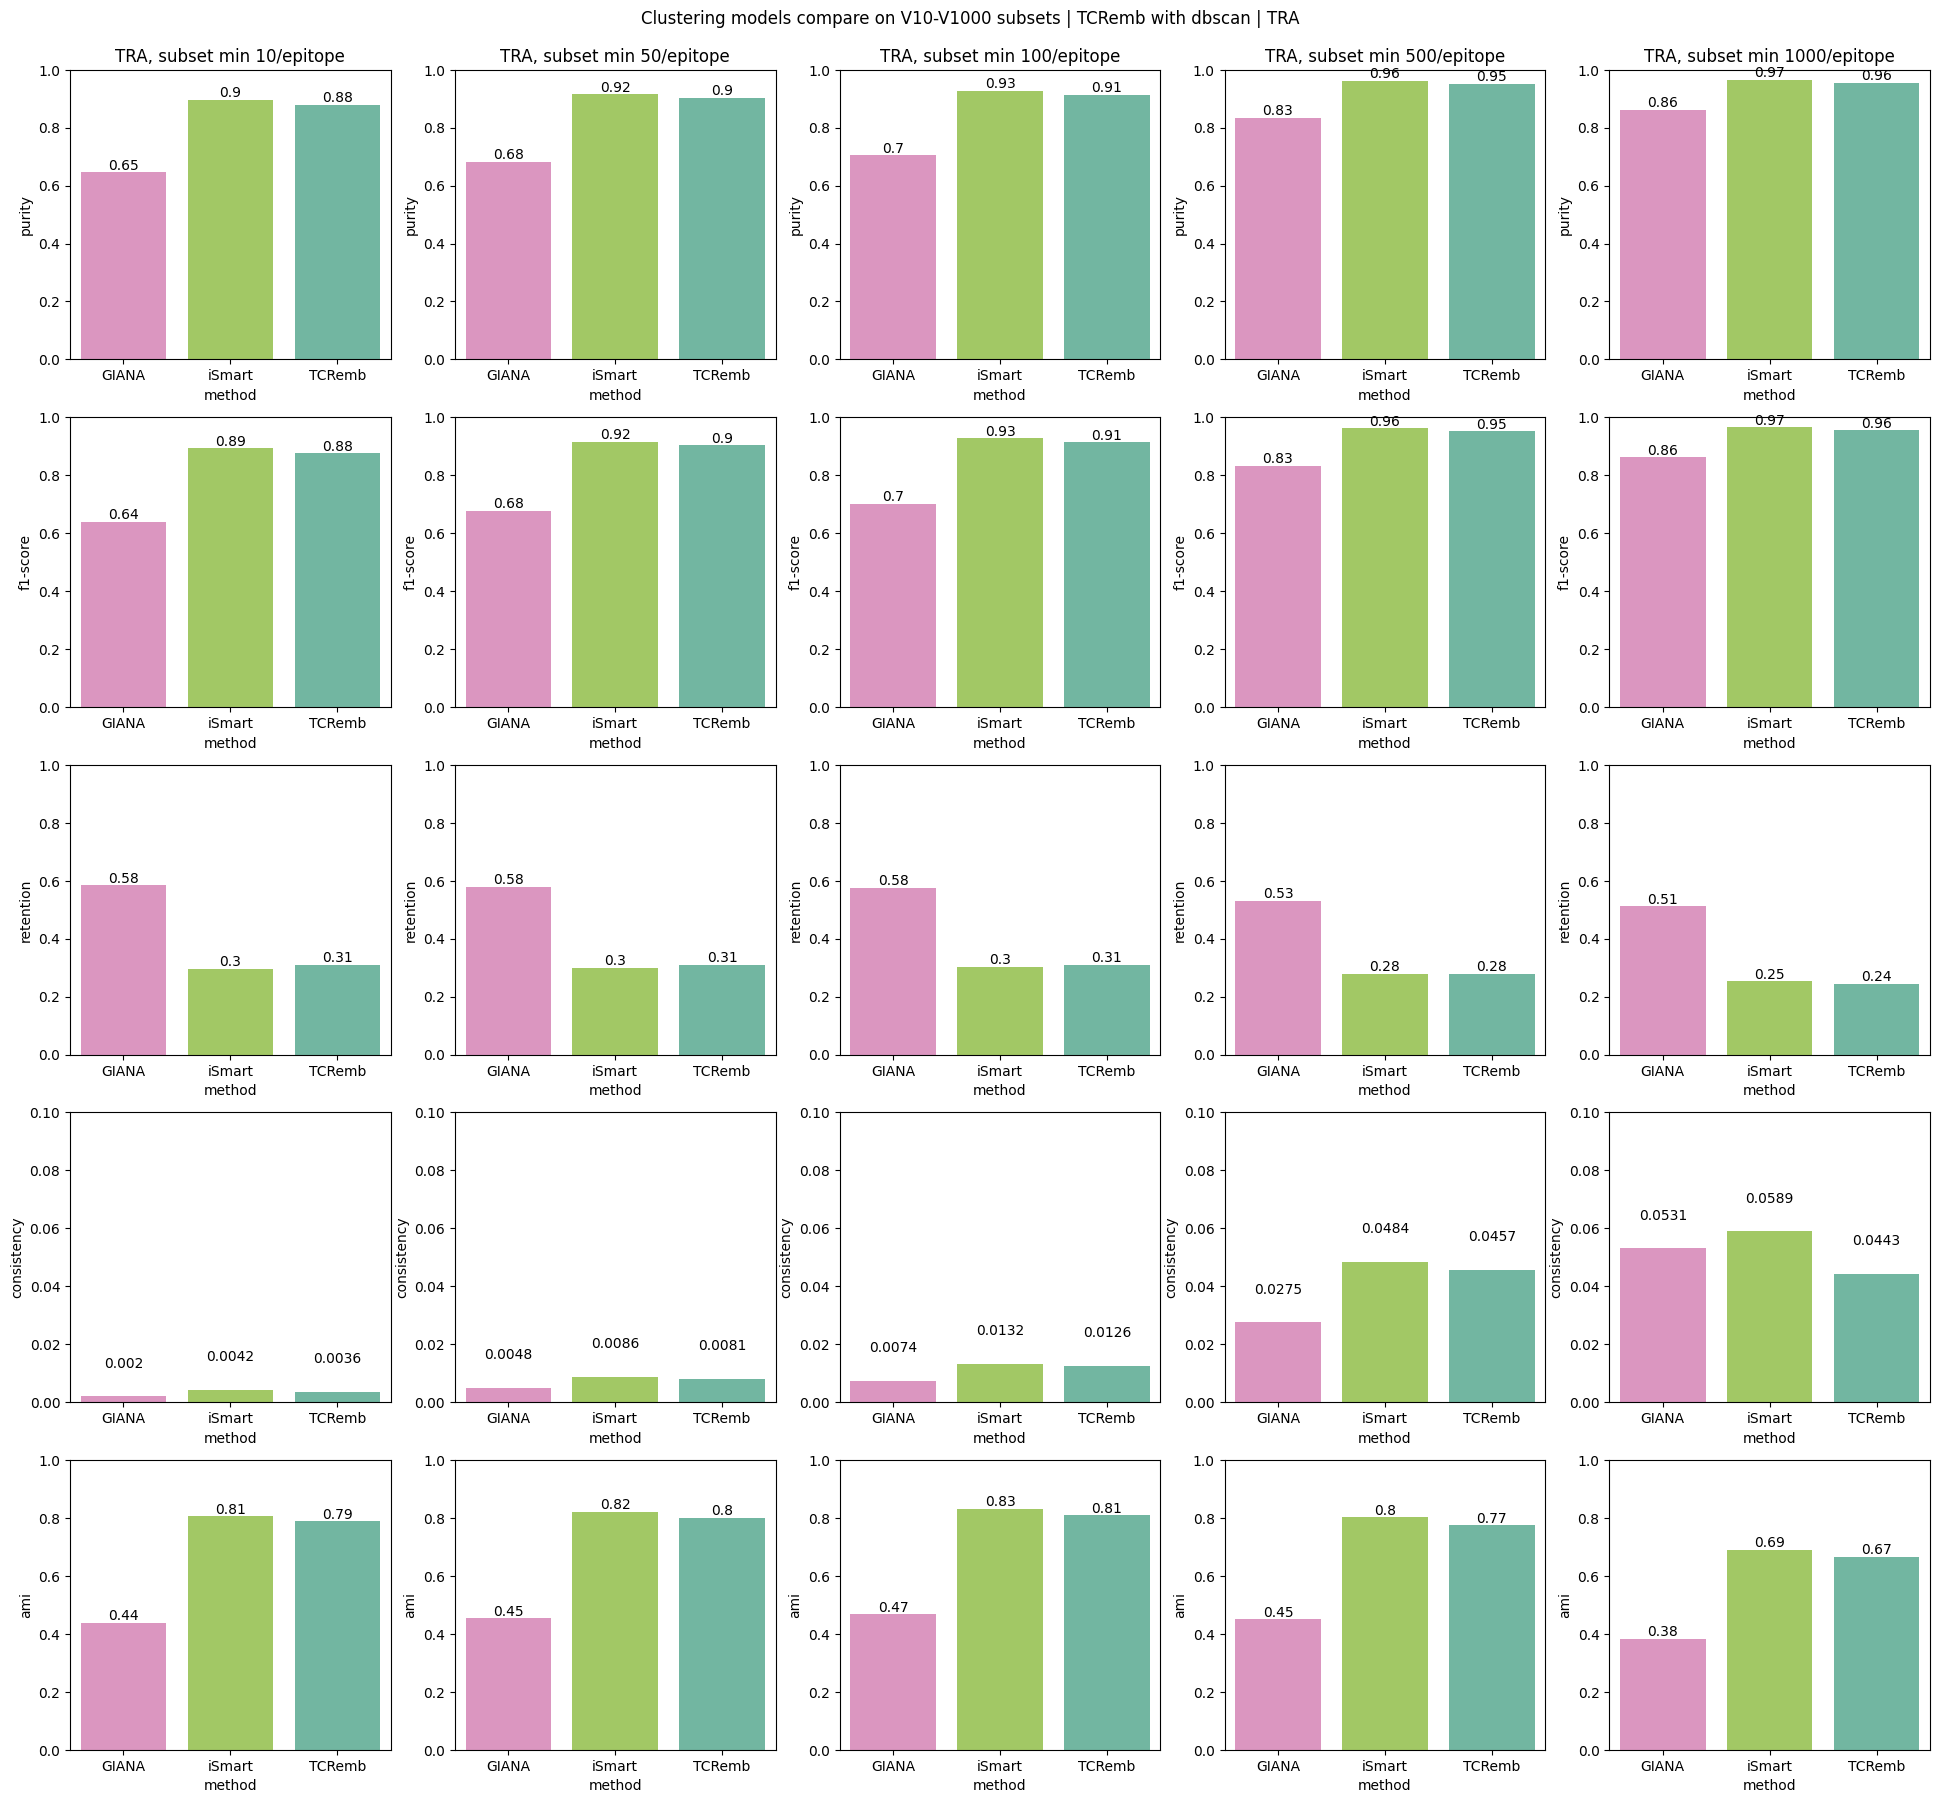

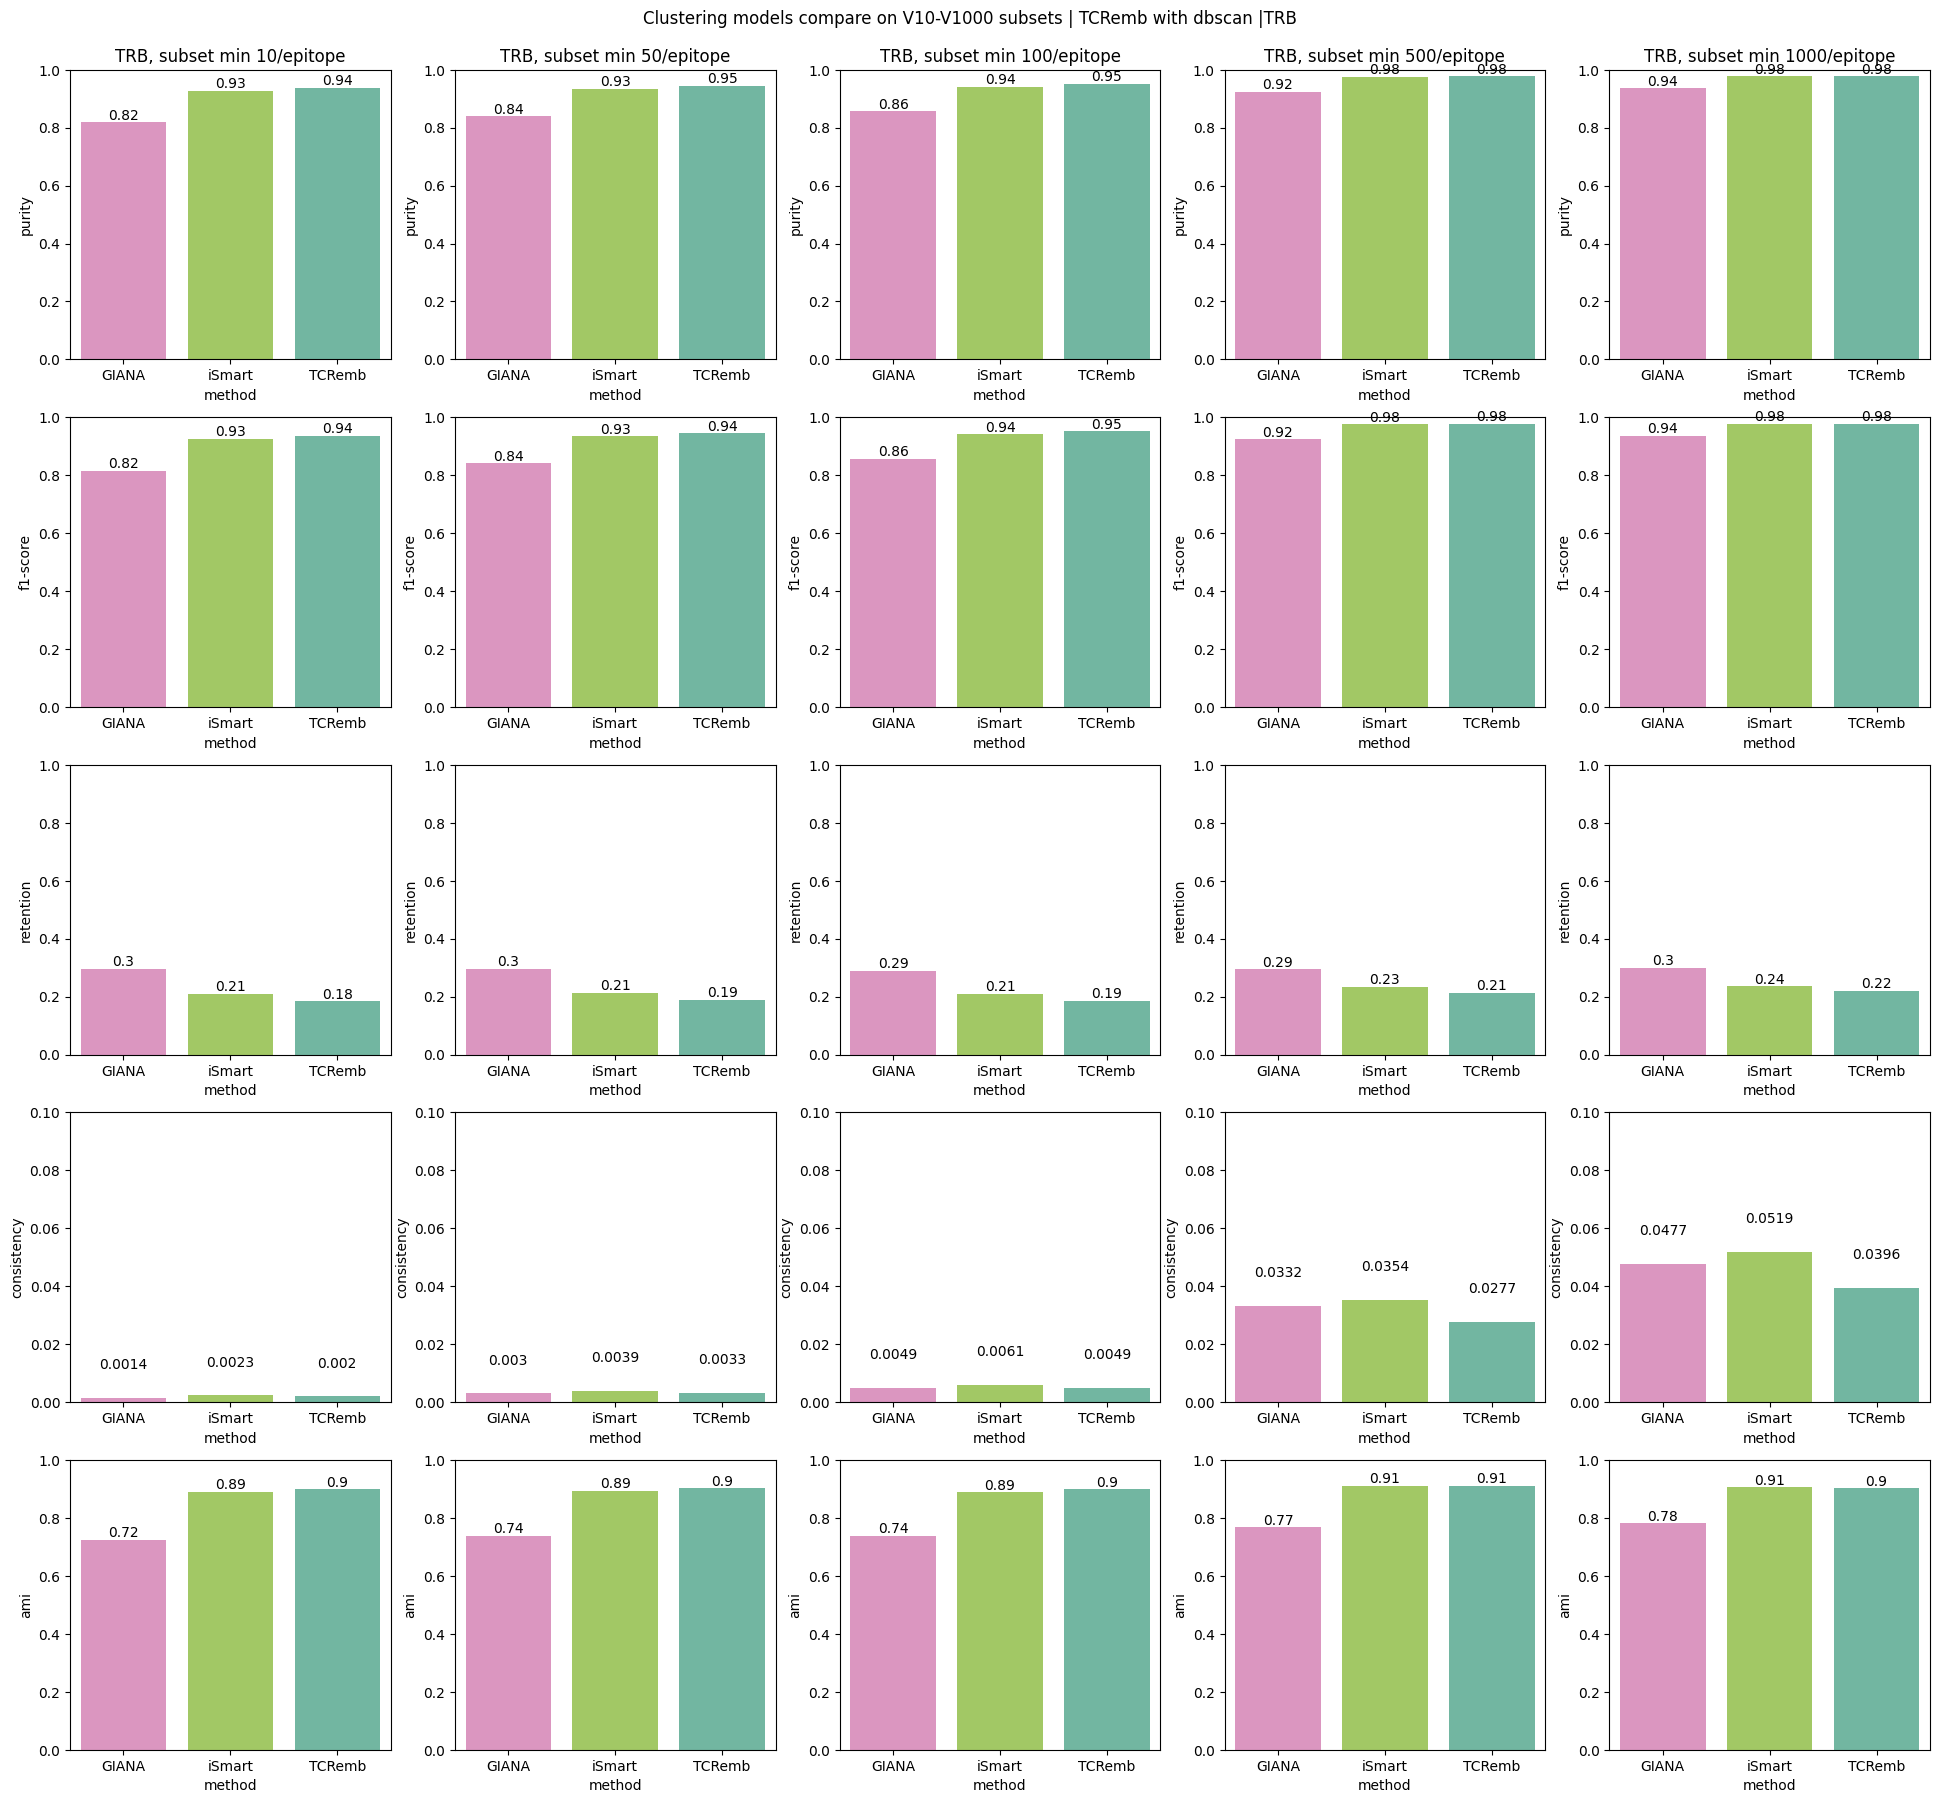

In [25]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"figures/fig5_dbscan_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"figures/fig5_dbscan_{chain}.png")

In [ ]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,18))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

In [ ]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [ ]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [ ]:
!pwd

In [ ]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

In [ ]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [ ]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [ ]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [ ]:
#atm_e = atm_e[atm_e['bind']==1]

In [ ]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [ ]:
roc_res


In [ ]:
atm_e[atm_e['pred'].isna()]